In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm  # <--- đây mới là hàm dùng để tạo progress bar

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf

# Kiểm tra danh sách các thiết bị GPU khả dụng
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU được phát hiện:")
    for gpu in gpus:
        print(gpu)
else:
    print("Không phát hiện thấy GPU.")


Không phát hiện thấy GPU.


In [43]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6700976480595130192
xla_global_id: -1
]


# **Image Captioning**

**What is Image Captioning ?**
- Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions.
- This task lies at the intersection of computer vision and natural language processing. Most image captioning systems use an encoder-decoder framework, where an input image is encoded into an intermediate representation of the information in the image, and then decoded into a descriptive text sequence.

**CNNs + RNNs (LSTMs)**
- To perform Image Captioning we will require two deep learning models combined into one for the training purpose
- CNNs extract the features from the image of some vector size aka the vector embeddings. The size of these embeddings depend on the type of pretrained network being used for the feature extraction
- LSTMs are used for the text generation process. The image embeddings are concatenated with the word embeddings and passed to the LSTM to generate the next word
- For a more illustrative explanation of this architecture check the Modelling section for a picture representation

In [3]:
image_path = '../Dataset/flickr30k/flickr30k_images'

In [4]:
data = pd.read_csv("../Dataset/flickr30k/captions.txt")
data.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,Two young White males are outside near many b...
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [5]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"D:/Hoc_Tap/Nam3_HK2/DeepLearning/CK/Dataset/flickr30k/flickr30k_images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

# **Visualization**
- Images and their corresponding captions

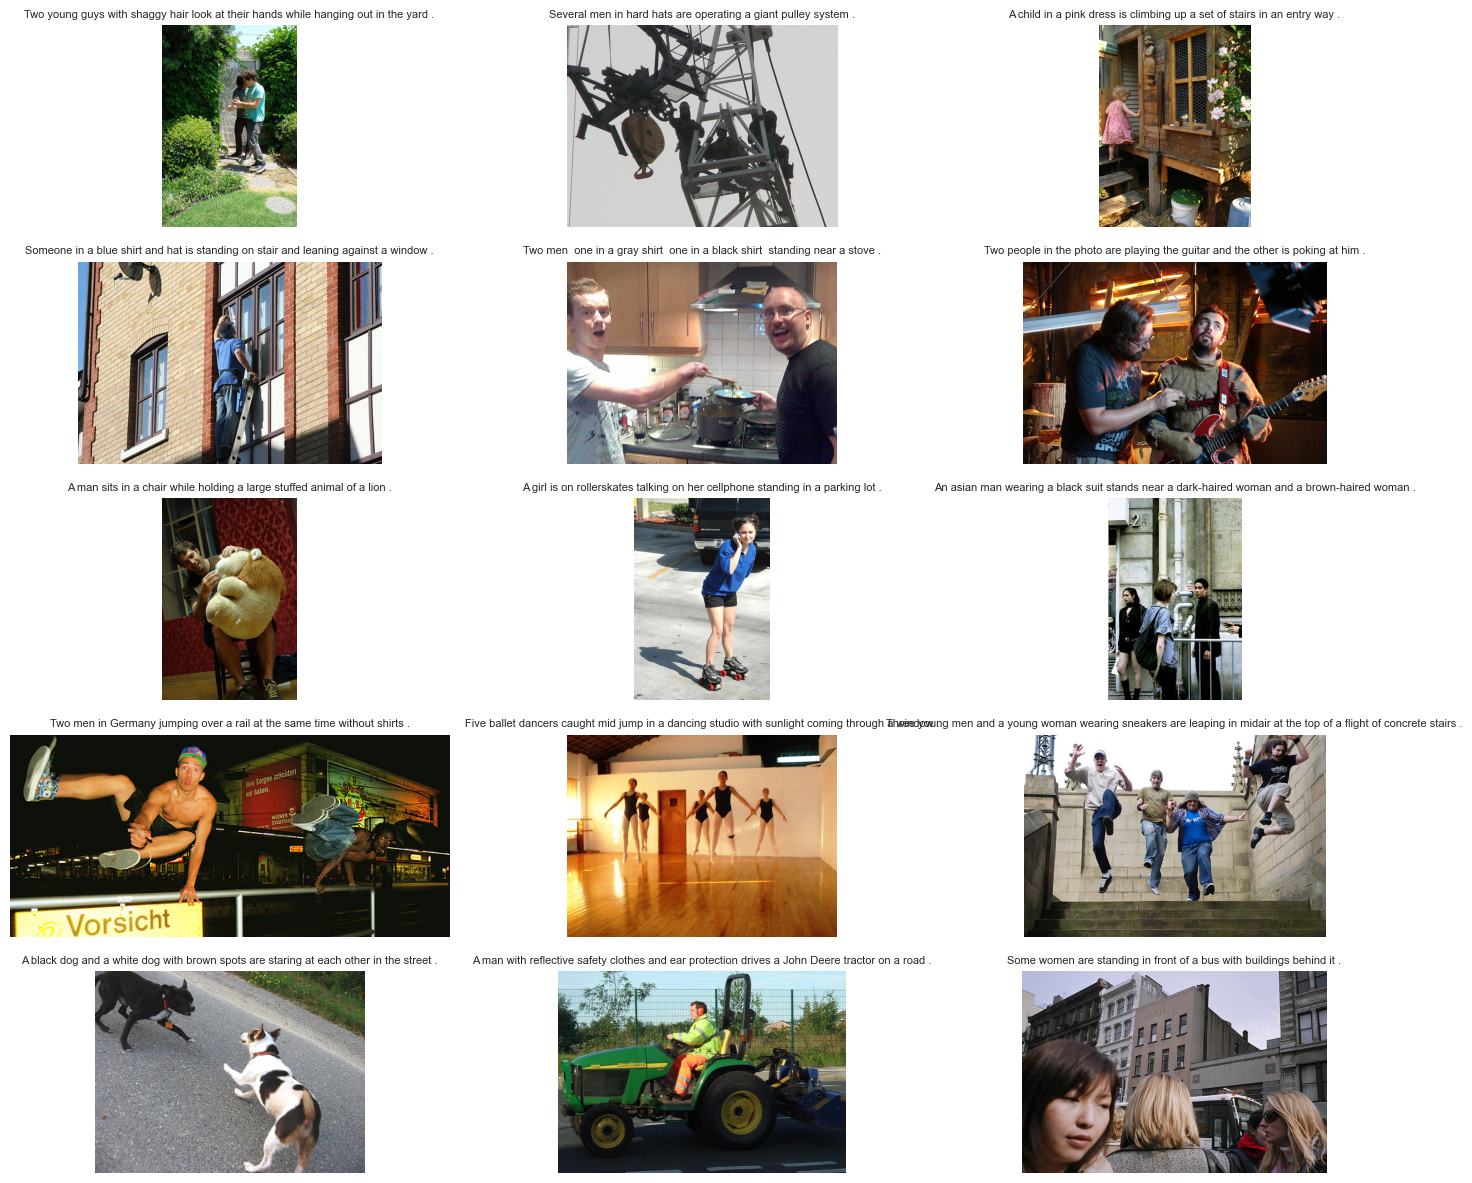

In [6]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

# Đường dẫn
image_dir = '../Dataset/flickr30k/flickr30k_images'
caption_file = '../Dataset/flickr30k/captions.txt'

# Đọc caption với pandas
df = pd.read_csv(caption_file)

# Lọc comment đầu tiên cho mỗi ảnh
df = df[df['comment_number'] == 0]

# Danh sách ảnh có thật trong thư mục
valid_rows = []
for _, row in df.iterrows():
    img_path = os.path.join(image_dir, row['image_name'])
    if os.path.exists(img_path):
        valid_rows.append(row)
    if len(valid_rows) == 15:
        break

# Hiển thị ảnh
plt.figure(figsize=(15, 12))
for idx, row in enumerate(valid_rows):
    img_name = row['image_name']
    caption = row['comment']
    img_path = os.path.join(image_dir, img_name)

    img = Image.open(img_path)
    plt.subplot(5, 3, idx + 1)
    plt.imshow(img)
    plt.title(caption, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [48]:
# display_images(data.sample(15))

# **Caption Text Preprocessing Steps**
- Convert sentences into lowercase
- Remove special characters and numbers present in the text
- Remove extra spaces
- Remove single characters
- Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

<img src='http://zjpnrm2br14wspo448nls17u-wpengine.netdna-ssl.com/wp-content/uploads/2020/09/processing-steps.png' >

In [5]:
def text_preprocessing(data):
    data['comment'] = data['comment'].apply(lambda x: x.lower())
    data['comment'] = data['comment'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['comment'] = data['comment'].apply(lambda x: x.replace("\s+"," "))
    data['comment'] = data['comment'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['comment'] = "startseq "+data['comment']+" endseq"
    return data

## __Preprocessed Text__

In [6]:
data = text_preprocessing(data)
captions = data['comment'].tolist()
captions[:10]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq several men in hard hats are operating giant pulley system endseq',
 'startseq workers look down from up above on piece of equipment endseq',
 'startseq two men working on machine wearing hard hats endseq',
 'startseq four men on top of tall structure endseq',
 'startseq three men on large rig endseq']

## __Tokenization and Encoded Representation__
- The words in a sentence are separated/tokenized and encoded in a one hot representation
- These encodings are then passed to the embeddings layer to generate word embeddings

<img src='https://lena-voita.github.io/resources/lectures/word_emb/lookup_table.gif'>

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image_name'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image_name'].isin(train_images)]
test = data[data['image_name'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 12, 21, 20, 708, 13, 54, 79, 194, 1421, 2]

# **Image Feature Extraction**
- DenseNet 201 Architecture is used to extract the features from the images
- Any other pretrained architecture can also be used for extracting features from these images
- Since the Global Average Pooling layer is selected as the final layer of the DenseNet201 model for our feature extraction, our image embeddings will be a vector of size 1920

<img src="https://imgur.com/wWHWbQt.jpg">

In [8]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)
img_size = 224
features = {}
for image in tqdm(data['image_name'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 31783/31783 [2:05:52<00:00,  4.21it/s]  


# **Data Generation**
- Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise
- The inputs will be the image embeddings and their corresonding caption text embeddings for the training process
- The text embeddings are passed word by word for the caption generation during inference time

In [9]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y


train_generator = CustomDataGenerator(df=train,X_col='image_name',y_col='comment',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image_name',y_col='comment',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

# **Modelling**
- The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network 
- The LSTM network starts generating words after each input thus forming a sentence at the end

In [10]:
from tensorflow.keras.utils import plot_model

input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')


from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model checkpoint
model_name = "model1.keras"  # Update the extension to .keras
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

history = caption_model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/20
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - loss: 5.3777
Epoch 1: val_loss improved from inf to 4.53303, saving model to model1.keras
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 1059s 501ms/step - loss: 5.3775 - val_loss: 4.5330 - learning_rate: 0.0010
Epoch 2/20
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - loss: 4.3346
Epoch 2: val_loss improved from 4.53303 to 4.29130, saving model to model1.keras
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 1138s 539ms/step - loss: 4.3346 - val_loss: 4.2913 - learning_rate: 0.0010
Epoch 3/20
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - loss: 4.1210
Epoch 3: val_loss improved from 4.29130 to 4.18743, saving model to model1.keras
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 1257s 596ms/step - loss: 4.1210 - val_loss: 4.1874 - learning_rate: 0.0010
Epoch 4/20
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - loss: 3.9884
Epoch 4: val_loss improved from 4.18743 to 4.13273, saving model to model1.keras
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 1362s 646ms/step - loss: 3.9884 - val_loss: 4.1

## **Learning Curve**
- The model has clearly overfit, possibly due to less amount of data
- We can tackle this problem in two ways
    1. Train the model on a larger dataset Flickr40k
    2. Attention Models

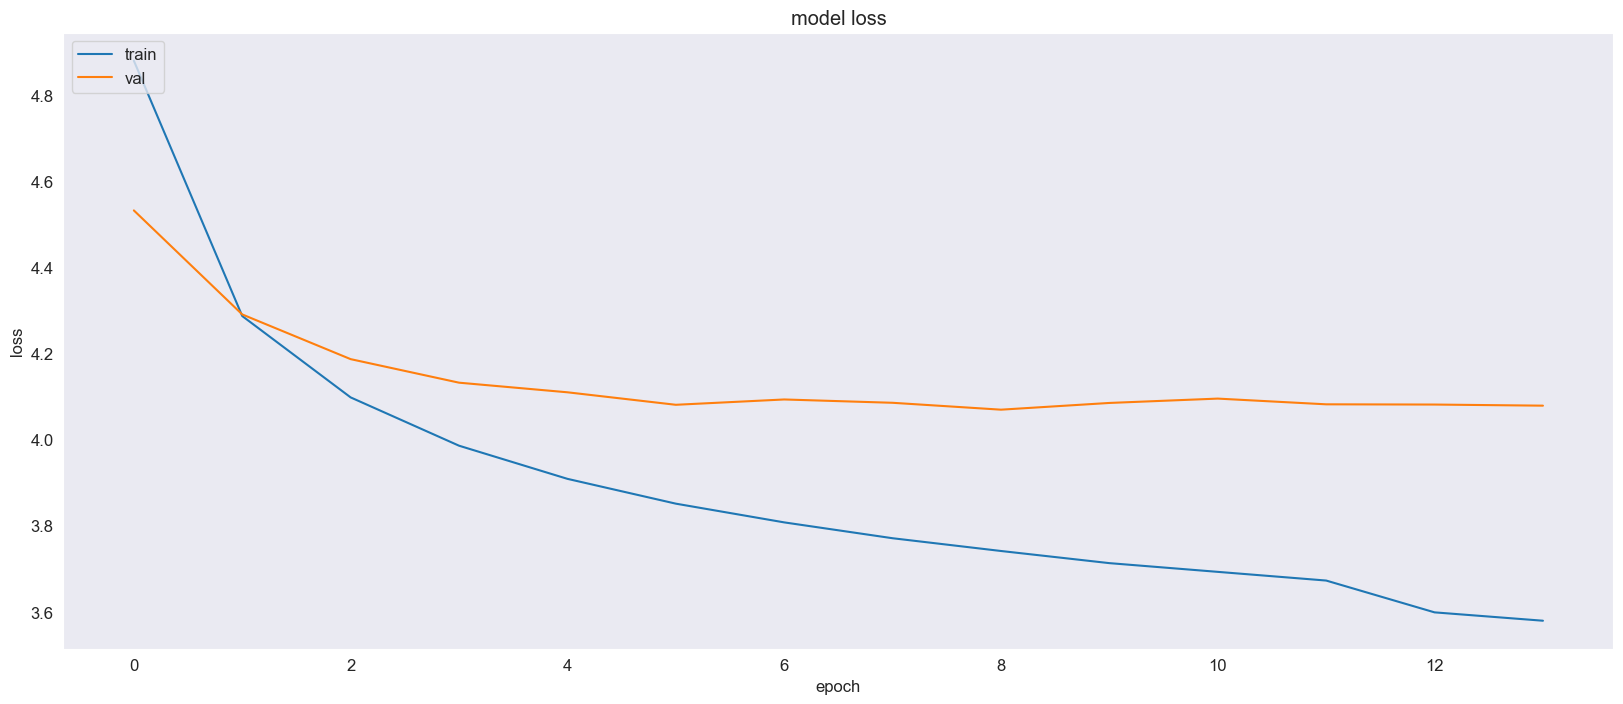

In [11]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## **Caption Generation Utility Functions**
- Utility functions to generate the captions of input images at the inference time.
- Here the image embeddings are passed along with the first word, followed by which the text embedding of each new word is passed to generate the next word

In [12]:
import pickle

# Save the tokenizer
with open("image_features1.pkl", "wb") as f:
    pickle.dump(tokenizer, f)



In [13]:
# Save the feature extractor model
fe.save("feature_extractor1.keras")


In [14]:
# Số lượng từ vựng trong tokenizer
vocab_size = len(tokenizer.word_index) + 1  # +1 vì có padding (thường là 0)

print("Vocabulary size:", vocab_size)


Vocabulary size: 18319


In [15]:
caption_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    491,776 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 74)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 256)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 74, 256)   │  4,689,664 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 75, 256)   │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dropout[0][0],    │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 18319)     │  2,363,151 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,308,399 (92.73 MB)

 Trainable params: 8,102,799 (30.91 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,205,600 (61.82 MB)

In [23]:
from tensorflow.keras.models import load_model

# Load lại mô hình từ file đã lưu
caption_model = load_model("model1.keras")


In [24]:
!pip install nltk



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm

# Hàm tạo caption từ ảnh
def generate_caption(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return in_text.replace('startseq ', '').replace(' endseq', '')

# Tính điểm BLEU
smooth = SmoothingFunction().method1
actual, predicted = list(), list()

for img_name in tqdm(test['image_name'].unique()):
    photo = features[img_name]
    y_pred = generate_caption(caption_model, tokenizer, photo, max_length)
    y_true = test[test['image_name'] == img_name]['comment'].tolist()
    y_true = [t.split() for t in y_true]
    
    actual.append(y_true)
    predicted.append(y_pred.split())

# BLEU-1 đến BLEU-4
from nltk.translate.bleu_score import corpus_bleu

print("BLEU-1:", corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2:", corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3:", corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4:", corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


100%|██████████| 4767/4767 [38:18<00:00,  2.07it/s]


BLEU-1: 0.45690887305327993
BLEU-2: 0.25650852775679855
BLEU-3: 0.14243969972248768
BLEU-4: 0.07378806896632056


In [26]:
def predict_caption_for_image(image_path, model, fe_model, tokenizer, max_length):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.
    img = np.expand_dims(img, axis=0)

    # Trích xuất đặc trưng từ ảnh
    photo = fe_model.predict(img, verbose=0)
    
    # Sinh caption
    caption = generate_caption(model, tokenizer, photo, max_length)
    return caption


Generated Caption: black dog is running in the grass


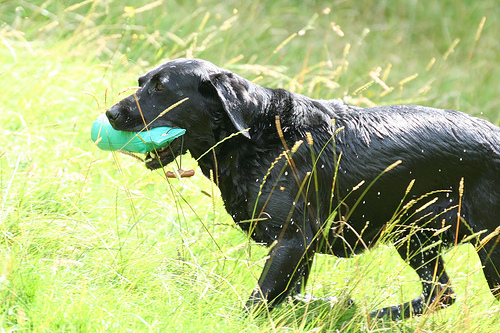

In [32]:
image_file = "../Image-Caption-Using-CNN-LSTM/img.png"
caption = predict_caption_for_image(image_file, caption_model, fe, tokenizer, max_length)
print("Generated Caption:", caption)

# Hiển thị ảnh
from PIL import Image
Image.open(image_file)


In [29]:
# Lưu tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Lưu features nếu bạn muốn dùng lại sau
with open("features.pkl", "wb") as f:
    pickle.dump(features, f)
